In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 85)
sns.set_theme(context="paper", font_scale=1.5, style="ticks", rc={"axes.grid": True})


# Calculating Feature Importance by Coefficients

The importance of a given feature to a logistic regressor can be assessed by finding the largest coefficients of its variables (as long as the features are scaled).

If we apply our PCA, the coefficients will correspond to the sum of mutations variable, the age variable, and the principal components.

***
## Load the data

In [2]:
# Read Data from CSV (NEW DATA, NOT SCALED)
df = pd.read_csv("../data/abnormal_writeout_noscale.data.csv", index_col=0)

# trascurare da ACC a UVM
start_drop = df.columns.get_loc("ACC")
end_drop = df.columns.get_loc("UVM")
cols = np.arange(start_drop, end_drop + 1)
df.drop(df.columns[cols], axis=1, inplace=True)

# trascurare alcune colonne
df.drop("TTT_freq", axis=1, inplace=True)
df.drop("oldest_phylostratum_factor", axis=1, inplace=True)
df.drop("gc_cds", axis=1, inplace=True) # ! New

# Drop NaNs
df.dropna(inplace=True)

# Sort features
resp = df["response"]
occ = df["occ_total_sum"]
age = df["oldest_phylostratum"]
conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)

# Collect Features and Labels
features_df = pd.DataFrame()
features_df["occ_total_sum"] = occ
features_df["oldest_phylostratum"] = age
features_df = pd.concat([features_df, conf], axis=1)

X = features_df.to_numpy()
y = df["response"].to_numpy()

features_df.head(5)

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

## Custom PCA

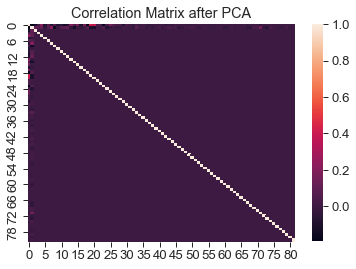

82 total features.
Confounder columns start from index 2 of feature matrix.
Non-counfounders: ['occ_total_sum', 'oldest_phylostratum']


,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Columns of confounder variables (highly colinear)
conf_index = 2
conf_cols = np.arange(2, X.shape[1])


class ConfounderPCA(BaseEstimator, TransformerMixin):
    """ 
    Custom PCA transformer for this dataset.
    Applies PCA only to the many collinear confounder 
    variables.
    
    cols - columns to which PCA will be applied.
    
    n_components - same as with the "vanilla" PCA. 
        If 0 < n_components < 1, select the number of 
        components such that the amount of variance that 
        needs to be explained is greater than the 
        percentage specified by n_components.
        
    apply_PCA - if false, simply returns the untransformed data.
    """

    def __init__(self, cols, n_components=None, apply_PCA=True):
        self.n_components = n_components
        self.apply_PCA = apply_PCA
        self.cols = cols
        if self.apply_PCA:
            self.pca = PCA(n_components=self.n_components)

    def fit(self, X, y=None):
        if self.apply_PCA:
            self.pca.fit(X[:, self.cols])
        return self

    def transform(self, X, y=None):
        if self.apply_PCA:
            X_pca = self.pca.transform(X[:, self.cols])
            return np.c_[X[:, :2], X_pca]
        else:
            return X


sns.heatmap(
    pd.DataFrame(
        ConfounderPCA(cols=np.arange(2, X.shape[1])).fit_transform(StandardScaler().fit_transform(X))
    ).corr()
)
plt.title("Correlation Matrix after PCA")
plt.show()

print(X.shape[1], "total features.")
print("Confounder columns start from index", conf_index, "of feature matrix.")
print("Non-counfounders:", features_df.iloc[:, 0:conf_index].columns.tolist())

features_df

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (14536, 82) (14536,)
Testing set shape: (3634, 82) (3634,)


# Train the model and rank its coefficients

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Model definition
lr_clf = Pipeline([
    # Apply scaling
    ("scaler", StandardScaler()),
    # Then apply PCA to the confounder variables, keeping all principal components
    ("pca", ConfounderPCA(n_components=None, cols=np.arange(2, X.shape[1]))),
    # Fit the l2 regularized logistic regression
    ("lr", LogisticRegression(max_iter=2000,)),
])

# Model training
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ConfounderPCA(cols=array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]))),
                ('lr', LogisticRegression(max_iter=2000))])

### Coefficients


In [6]:
# Collect the coefficients into a pandas dataframe
coef_df = pd.DataFrame(lr_clf["lr"].coef_.T, columns=["Beta"])

# Label the first two variables, and name the PCs "PC 1", etc
coef_df.rename(index={0 : "occ_total_sum", 1 : "oldest_phylostratum"}, inplace=True)
coef_df.rename(index=lambda s: s-1 if isinstance(s, int) else s, inplace=True)
coef_df.rename(index=lambda s: f"PC {s}" if isinstance(s, int) else s, inplace=True)

# Print the dataframe sorted by absolute value of coefficients
coef_df.sort_values(by="Beta", key=abs, ascending=False).head(5)

,Beta
PC 70,1.635399
PC 69,-1.286955
PC 79,1.196615
PC 77,1.050856
PC 66,0.925432


In [7]:
coef_df.to_csv("./data/lr/lr_betas.csv")

### PC Loadings

In [8]:
# collect the loadings of the pca object into a pandas dataframe
loadings_df = pd.DataFrame(lr_clf["pca"].pca.components_.T, index = features_df.columns[2:])

# Rename PCs
loadings_df.rename(columns=lambda s: f"PC {s+1}", inplace=True)

# Get the indices of the top principal components
idx = coef_df[2:].sort_values(by="Beta", key=abs, ascending=False).index

# Print the loadings with columns (components) sorted by absolute value of their coefficient
loadings_df.loc[:, idx].T.head(5)

,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
PC 70,-0.008390,0.000986,0.002954,-0.000876,0.003247,-0.001306,0.002005,-0.000028,0.000719,0.000238,-0.000751,-0.001469,0.001703,0.000177,-0.001089,0.002204,-0.000281,0.000516,-0.062434,-0.082791,0.042317,0.031024,-0.025427,-0.055181,0.044341,-0.320590,-0.126107,-0.216218,-0.019223,-0.023991,-0.045215,0.002126,0.005128,0.045508,-0.034505,-0.013280,0.064399,0.080429,-0.001677,-0.070114,0.117802,-0.070573,-0.009428,-0.124377,0.045590,0.015762,-0.014499,0.091075,0.050520,0.427336,0.138849,0.274437,0.263634,0.108425,0.103890,0.014647,0.171005,-0.019549,0.135487,0.001350,0.107304,0.047856,0.028936,0.114472,0.083826,-0.021471,-0.055545,-0.037736,0.028713,-0.012593,-0.073677,-0.074532,0.008800,-0.318394,-0.245010,-0.313536,-0.112809,-0.027398,-0.055391,-0.001057
PC 69,0.007028,-0.002392,0.000149,0.000460,0.000425,-0.003012,-0.001223,-0.005176,0.004302,-0.001291,0.001540,-0.001096,0.002896,-0.001184,0.000126,-0.001506,0.000707,-0.037734,-0.184417,-0.319938,-0.334203,-0.037801,-0.091484,-0.080628,-0.067455,0.109652,-0.155315,-0.140610,0.175490,0.048553,-0.015627,-0.025365,-0.000713,0.218188,0.008139,0.021168,-0.030456,0.064313,-0.031230,-0.031246,-0.002295,0.125014,-0.043225,-0.017462,0.201155,0.058003,0.013205,0.048380,0.047794,0.158898,-0.086586,-0.136231,-0.130323,0.072218,0.008026,-0.007046,0.026545,0.199460,-0.051507,-0.023684,0.231161,-0.130620,-0.194164,-0.305815,-0.211595,0.140564,-0.035629,-0.015828,-0.079538,0.012888,-0.056300,-0.036656,-0.056217,0.126431,-0.117621,-0.090563,0.276829,0.021277,-0.043851,-0.041441
PC 79,-0.000331,-0.000187,0.000569,-0.000114,0.000675,-0.000461,0.000249,-0.001188,0.000405,-0.000063,-0.000262,-0.000019,0.000080,-0.000302,-0.000024,0.000038,-0.000045,-0.000829,0.019417,-0.006967,0.004048,-0.039585,-0.052163,-0.022544,-0.040613,-0.000619,0.003357,0.002726,0.000371,-0.369122,0.131527,-0.000656,0.010318,0.017839,0.038763,0.015990,0.017018,0.018903,-0.000078,0.036027,0.002245,0.002571,0.011941,0.009404,0.002866,-0.210333,0.217511,0.054922,0.037078,0.006625,0.022431,-0.000217,0.006219,-0.015439,-0.063639,-0.013088,-0.036588,-0.003379,0.000765,-0.000755,-0.001257,-0.207323,0.108262,0.005047,0.009697,0.351458,0.261293,0.210561,0.381693,-0.182604,-0.204309,-0.109302,-0.213189,-0.008250,-0.004812,-0.005024,-0.005188,-0.376210,0.148070,-0.009463
PC 77,0.000840,0.000522,-0.000784,-0.000887,-0.000083,0.001002,0.000282,-0.000283,-0.000891,-0.000027,-0.000915,-0.000091,0.001114,-0.000019,0.000114,-0.000464,0.000071,0.001322,-0.147061,-0.001333,0.014238,0.343873,0.196064,0.204226,0.159246,0.069864,-0.083422,0.019711,0.006683,-0.045477,0.059527,0.000113,-0.015022,-0.186131,-0.339393,-0.226651,-0.151723,0.172525,0.000753,0.115716,-0.004428,-0.050659,-0.317712,-0.144991,-0.062471,-0.044575,0.056152,-0.042268,-0.031590,-0.069218,-0.180159,-0.055595,-0.027930,0.236497,0.218382,0.309078,0.130484,0.025470,-0.161488,0.001593,-0.005564,-0.023126,0.048590,0.001717,-0.007147,0.032034,-0.094027,0.017592,0.047659,0.084277,-0.049277,0.014240,-0.055832,0.033598,-0.106506,0.009524,-0.001526,-0.031064,0.081028,0.011679
PC 66,0.017538,0.003544,-0.000303,-0.001048,0.013568,-0.003351,0.000547,-0.006800,-0.000843,0.004370,-0.011326,0.002783,-0.002515,-0.002218,-0.006975,0.018

In [9]:
print("Top Loadings of top PCs")
sorted_loadings_df = loadings_df.loc[:, idx].T
for i in range(4):
    print(sorted_loadings_df.iloc[i, :].sort_values(axis=0,key=abs, ascending=False)[0:4])

Top Loadings of top PCs
GAA_freq    0.427336
AGA_freq   -0.320590
TGA_freq   -0.318394
TGG_freq   -0.313536
Name: PC 70, dtype: float64
AAT_freq   -0.334203
AAG_freq   -0.319938
GTG_freq   -0.305815
TGT_freq    0.276829
Name: PC 69, dtype: float64
TAT_freq    0.381693
TTA_freq   -0.376210
ATA_freq   -0.369122
TAA_freq    0.351458
Name: PC 79, dtype: float64
ACA_freq    0.343873
CAC_freq   -0.339393
CGC_freq   -0.317712
GCG_freq    0.309078
Name: PC 77, dtype: float64


In [10]:
sorted_loadings_df.to_csv("./data/lr/lr_sorted_loadings.csv")
loadings_df.to_csv("./data/lr/lr_loadings.csv")

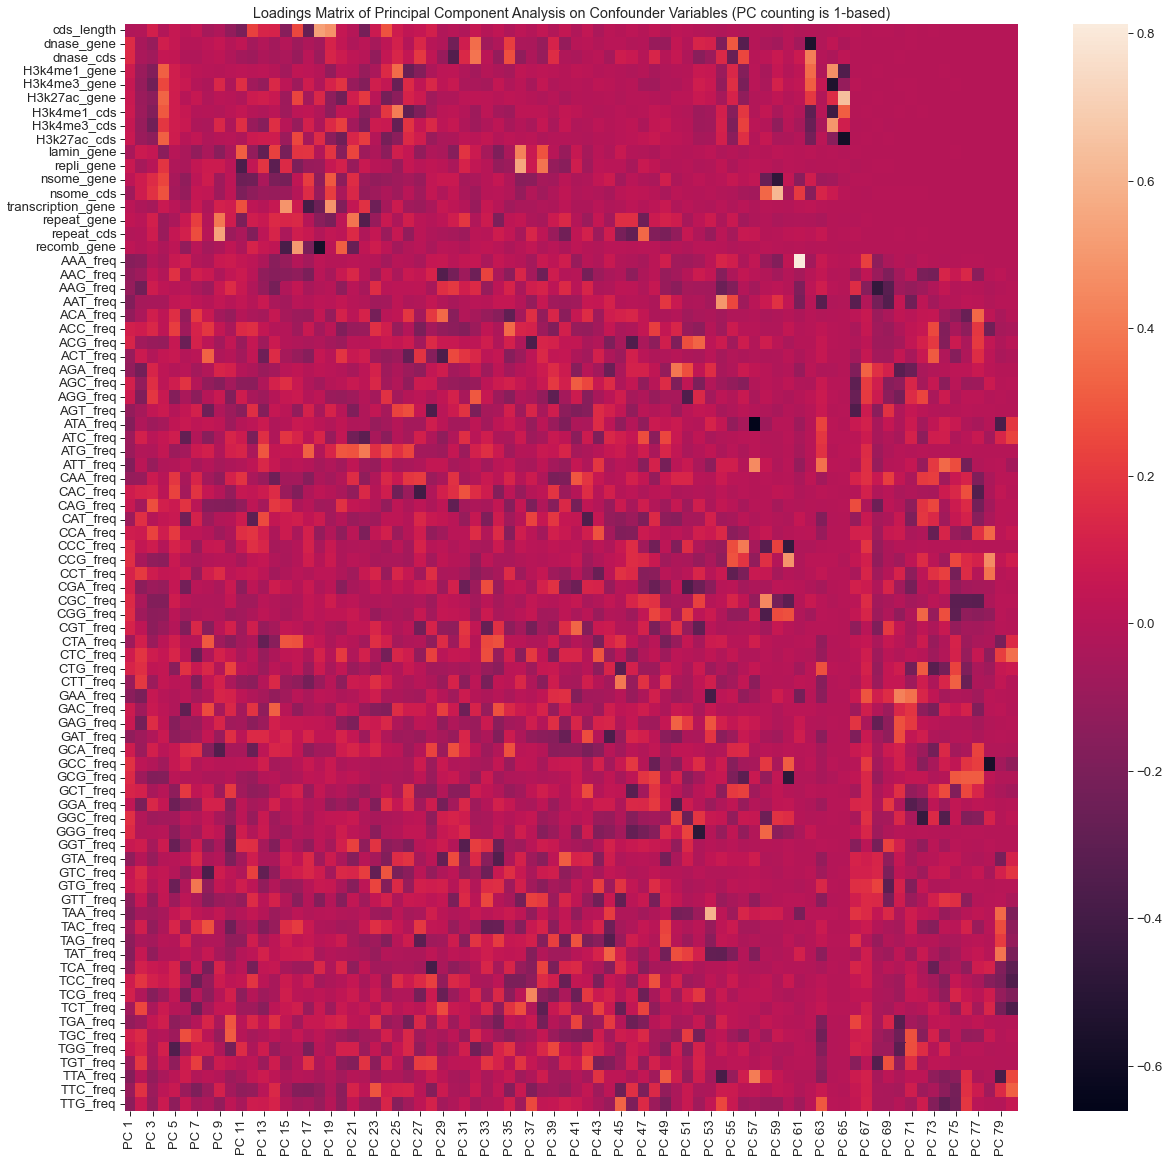

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(loadings_df)
plt.title("Loadings Matrix of Principal Component Analysis on Confounder Variables (PC counting is 1-based)")
plt.show()